In [1]:
# Paths
import os
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

os.chdir('../..')
from pcmf import pcmf_full, path_plot, plot_ordercolor, plot_cluster_assignments, PCMF_predict_clusters
from p3ca import cluster_metrics, calculate_scores_nonpath
import numpy as np
%load_ext autoreload


In [37]:
# Functions
def run_fitPCMF_experiment_consensusICML2023(savedir='/athena/listonlab/store/amb2022/PCMF/results_ICML2023/',dataset='MNIST', problem_rank=100, rho=2.0, gc=1.0, neighbors=40, admm_iters=2, penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,10))[::-1]),axis=0), skip=1, labels_keep=[0,1,2,3,4,5], data_path='/athena/listonlab/store/amb2022/clusterCCA_revision1/clusterCCA/data/',randomize=False):
    from pcmf import pcmf_full_consensus_2023 as pcmf_consensus
    import time
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    # LOAD DATA
    batch_size = 50
    if dataset == 'MNIST':
        save_path=savedir+'MNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_MNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'FashionMNIST':
        save_path=savedir+'FashionMNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_FashionMNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'GBMBreastLung':
        save_path=savedir+'GBMBreastLung_'+'skip'+str(skip)+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters  = load_GBMBreastLung(data_path=data_path, plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'Synthetic':
        save_path=savedir+'Synthetic100000_'+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, num_clusters, u_true, v_true = load_syntheticDataConsensus(n=100000, n_test=10000, p=1000, m=25000, m_test=2500, plot=False, randomize=randomize)
        true_clusters_labels = []
    else:
        print('Dataset not implemented:',dataset)
        return
    
    print('Problem rank',problem_rank)
    print('Save path is:',save_path+'.npz')

    # STANDARDIZE DATA
    scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
    X_in = scaler.transform(X_in)
    normalizer = Normalizer().fit(X_in)
    X_in = normalizer.transform(X_in)
    scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
    X_in = scaler2.transform(X_in)

    X_in_test = scaler.transform(X_in_test)
    X_in_test = normalizer.transform(X_in_test)
    X_in_test = scaler2.transform(X_in_test)

    # Fit PCMF
    tic=time.time()
    A_list, U_list, s_list, V_list = pcmf_consensus(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
    toc=time.time() - tic
    
    A = A_list
    U = U_list
    S = s_list
    V = V_list

    X_compA = []
    X_compB = []
    UV = []
    USV = []
    for p in range(len(penalty_list)):
        x_pcmf = U[p]*S[p][:,0] # should the 0 be here??
        x_pcmf2 = (X_in[:,:] @ V[p].T) 
        X_compA.append(np.array(x_pcmf))
        X_compB.append(np.array(x_pcmf2))
        UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
        USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

    X_compA=np.asarray(X_compA)
    X_compB=np.asarray(X_compB)
    
    # SAVE DATASET    
#     X_in=X_in, 
# X_in_test=X_in_test, 
    np.savez(save_path+".npz",  A=A, U=U, S=S, V=V, UV=UV, USV=USV, X_compA=X_compA, X_compB=X_compB, true_clusters_in=true_clusters_in, true_clusters_in_test=true_clusters_in_test, true_clusters_labels=true_clusters_labels, num_clusters=num_clusters, u_true=u_true, v_true=v_true, split_size=batch_size, runtime=toc, penalty_list=np.asarray(penalty_list), rho=rho, admm_iters=admm_iters, gc=gc, neighbors=neighbors) 
#     generate_plots_synthetic(A, U, V, S, split_size, penalty_list, true_clusters_all, save_path+".pdf")
    del A, U, S, V, UV, USV, X_compA, X_compB, true_clusters_in, toc

    return save_path+".npz", X_in, X_in_test

from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog, linear_sum_assignment as linear_assignment

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

# Synthetic data
def load_syntheticDataConsensus(n=100000, n_test=10000, p=1000, m=25000, m_test=2500, num_clusters=4, means=[-1.0, 1.0, -0.4, 0.4], r=1, sigma=0.075, density=0.5, plot=False, randomize=False, pcmf_dir="/athena/listonlab/store/amb2022/PCMF/"):
    import numpy as np
    import os
    os.chdir(pcmf_dir)
    from pcmf import generate_cluster_PMD_data
    print('Loading synthetic data, run: '+str(r))
    seeds = [r,r+1,r+2,r+3]
    
    # Cluster sizes
    ms = [m+m_test,m+m_test,m+m_test,m+m_test]
    
    # Get clustered CCA data
    X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(ms, p, sigma, density, num_clusters, means=means) 
    # Training set
    X_c_train = []
    X_in_test = []
    for nc in range(num_clusters):
        X_c_train.append(X_clusters[nc][0:m,:])
        X_in_test.append(X_clusters[nc][m:m+m_test,:])
    X_c_train = np.vstack(X_c_train)
    true_clusters = np.repeat([0,1,2,3],m)
    # Test set
    X_in_test = np.vstack(X_in_test)
    true_clusters_in_test = np.repeat([0,1,2,3],m_test)
    
    # Shape of dataset
    print('X_c_train: ' + str(X_c_train.shape))
    print('Y_train: ' + str(true_clusters.shape))
    print('X_c_test:  '  + str(X_in_test.shape))
    print('Y_test:  '  + str(true_clusters_in_test.shape))
    
    # Randomize training setorder
    if randomize is True:
        print('Randomizing order seed 1234')
        idx_perm = np.random.RandomState(seed=1234).permutation(X_c_train.shape[0])
        X_in = X_c_train[idx_perm,:]
        true_clusters_in = true_clusters[idx_perm]
    else:
        X_in = X_c_train
        true_clusters_in = true_clusters
    
    return X_in, true_clusters_in, X_in_test, true_clusters_in_test, num_clusters, u_true, v_true


    


In [38]:
X_in, true_clusters_in, X_in_test, true_clusters_in_test, num_clusters, u_true, v_true = load_syntheticDataConsensus(n=100000, n_test=10000, p=10, m=25000, m_test=2500, plot=False, randomize=False)



Loading synthetic data, run: 1
X_c_train: (100000, 10)
Y_train: (100000,)
X_c_test:  (10000, 10)
Y_test:  (10000,)


In [39]:
# savedir = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/'
# data_path = '/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/'
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,5))[::-1]),axis=0)
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,5))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,3))[::-1]),axis=0)

# penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(-10,10,1))[::-1]),axis=0)

# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,20))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(-100,10,15))[::-1]),axis=0)
randomize = False
rho = 2.0
gc = 1.0
neighbors = 40
admm_iters = 2#2#15
skip = 1#20
labels_keep = [0,1,2,3,4,5]
problem_rank=8
data_path, X_in, X_in_test = run_fitPCMF_experiment_consensusICML2023(dataset='Synthetic', problem_rank=problem_rank, rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, randomize=randomize)



Loading synthetic data, run: 1
X_c_train: (100000, 1000)
Y_train: (100000,)
X_c_test:  (10000, 1000)
Y_test:  (10000,)
Problem rank 8
Save path is: /athena/listonlab/store/amb2022/PCMF/results_ICML2023/Synthetic100000__batchSize_50_pathLength17problem_rank8_gausscoef1.0_neighbors40_admm_iters2_rho2.0_randomizeFalse.npz
weights: Gaussian neighbors: 40 gauss_coef: 1.0 rho: 2.0
rho1: 2.0 rho2 2.0
Number of batches: 2000
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Initialize IDX: 4
Initialize IDX: 5
Initialize IDX: 6
Initialize IDX: 7
Initialize IDX: 8
Initialize IDX: 9
Initialize IDX: 10
Initialize IDX: 11
Initialize IDX: 12
Initialize IDX: 13
Initialize IDX: 14
Initialize IDX: 15
Initialize IDX: 16
Initialize IDX: 17
Initialize IDX: 18
Initialize IDX: 19
Initialize IDX: 20
Initialize IDX: 21
Initialize IDX: 22
Initialize IDX: 23
Initialize IDX: 24
Initialize IDX: 25
Initialize IDX: 26
Initialize IDX: 27
Initialize IDX: 28
Initialize IDX: 29
Initialize IDX: 30


Initialize IDX: 407
Initialize IDX: 408
Initialize IDX: 409
Initialize IDX: 410
Initialize IDX: 411
Initialize IDX: 412
Initialize IDX: 413
Initialize IDX: 414
Initialize IDX: 415
Initialize IDX: 416
Initialize IDX: 417
Initialize IDX: 418
Initialize IDX: 419
Initialize IDX: 420
Initialize IDX: 421
Initialize IDX: 422
Initialize IDX: 423
Initialize IDX: 424
Initialize IDX: 425
Initialize IDX: 426
Initialize IDX: 427
Initialize IDX: 428
Initialize IDX: 429
Initialize IDX: 430
Initialize IDX: 431
Initialize IDX: 432
Initialize IDX: 433
Initialize IDX: 434
Initialize IDX: 435
Initialize IDX: 436
Initialize IDX: 437
Initialize IDX: 438
Initialize IDX: 439
Initialize IDX: 440
Initialize IDX: 441
Initialize IDX: 442
Initialize IDX: 443
Initialize IDX: 444
Initialize IDX: 445
Initialize IDX: 446
Initialize IDX: 447
Initialize IDX: 448
Initialize IDX: 449
Initialize IDX: 450
Initialize IDX: 451
Initialize IDX: 452
Initialize IDX: 453
Initialize IDX: 454
Initialize IDX: 455
Initialize IDX: 456


Initialize IDX: 822
Initialize IDX: 823
Initialize IDX: 824
Initialize IDX: 825
Initialize IDX: 826
Initialize IDX: 827
Initialize IDX: 828
Initialize IDX: 829
Initialize IDX: 830
Initialize IDX: 831
Initialize IDX: 832
Initialize IDX: 833
Initialize IDX: 834
Initialize IDX: 835
Initialize IDX: 836
Initialize IDX: 837
Initialize IDX: 838
Initialize IDX: 839
Initialize IDX: 840
Initialize IDX: 841
Initialize IDX: 842
Initialize IDX: 843
Initialize IDX: 844
Initialize IDX: 845
Initialize IDX: 846
Initialize IDX: 847
Initialize IDX: 848
Initialize IDX: 849
Initialize IDX: 850
Initialize IDX: 851
Initialize IDX: 852
Initialize IDX: 853
Initialize IDX: 854
Initialize IDX: 855
Initialize IDX: 856
Initialize IDX: 857
Initialize IDX: 858
Initialize IDX: 859
Initialize IDX: 860
Initialize IDX: 861
Initialize IDX: 862
Initialize IDX: 863
Initialize IDX: 864
Initialize IDX: 865
Initialize IDX: 866
Initialize IDX: 867
Initialize IDX: 868
Initialize IDX: 869
Initialize IDX: 870
Initialize IDX: 871


Initialize IDX: 1235
Initialize IDX: 1236
Initialize IDX: 1237
Initialize IDX: 1238
Initialize IDX: 1239
Initialize IDX: 1240
Initialize IDX: 1241
Initialize IDX: 1242
Initialize IDX: 1243
Initialize IDX: 1244
Initialize IDX: 1245
Initialize IDX: 1246
Initialize IDX: 1247
Initialize IDX: 1248
Initialize IDX: 1249
Initialize IDX: 1250
Initialize IDX: 1251
Initialize IDX: 1252
Initialize IDX: 1253
Initialize IDX: 1254
Initialize IDX: 1255
Initialize IDX: 1256
Initialize IDX: 1257
Initialize IDX: 1258
Initialize IDX: 1259
Initialize IDX: 1260
Initialize IDX: 1261
Initialize IDX: 1262
Initialize IDX: 1263
Initialize IDX: 1264
Initialize IDX: 1265
Initialize IDX: 1266
Initialize IDX: 1267
Initialize IDX: 1268
Initialize IDX: 1269
Initialize IDX: 1270
Initialize IDX: 1271
Initialize IDX: 1272
Initialize IDX: 1273
Initialize IDX: 1274
Initialize IDX: 1275
Initialize IDX: 1276
Initialize IDX: 1277
Initialize IDX: 1278
Initialize IDX: 1279
Initialize IDX: 1280
Initialize IDX: 1281
Initialize ID

Initialize IDX: 1628
Initialize IDX: 1629
Initialize IDX: 1630
Initialize IDX: 1631
Initialize IDX: 1632
Initialize IDX: 1633
Initialize IDX: 1634
Initialize IDX: 1635
Initialize IDX: 1636
Initialize IDX: 1637
Initialize IDX: 1638
Initialize IDX: 1639
Initialize IDX: 1640
Initialize IDX: 1641
Initialize IDX: 1642
Initialize IDX: 1643
Initialize IDX: 1644
Initialize IDX: 1645
Initialize IDX: 1646
Initialize IDX: 1647
Initialize IDX: 1648
Initialize IDX: 1649
Initialize IDX: 1650
Initialize IDX: 1651
Initialize IDX: 1652
Initialize IDX: 1653
Initialize IDX: 1654
Initialize IDX: 1655
Initialize IDX: 1656
Initialize IDX: 1657
Initialize IDX: 1658
Initialize IDX: 1659
Initialize IDX: 1660
Initialize IDX: 1661
Initialize IDX: 1662
Initialize IDX: 1663
Initialize IDX: 1664
Initialize IDX: 1665
Initialize IDX: 1666
Initialize IDX: 1667
Initialize IDX: 1668
Initialize IDX: 1669
Initialize IDX: 1670
Initialize IDX: 1671
Initialize IDX: 1672
Initialize IDX: 1673
Initialize IDX: 1674
Initialize ID

In [48]:
pwd

'/athena/listonlab/store/amb2022/PCMF'

In [49]:
data_path = '/athena/listonlab/store/amb2022/PCMF/results_ICML2023/Synthetic100000__batchSize_50_pathLength15_gausscoef1.0_neighbors40_admm_iters2_rho2.0.npz'
results = np.load(data_path, allow_pickle=True)

A = results['A']
U = results['U']
V = results['V']
S = results['S']
UV = results['UV']
USV = results['USV']
X_compA = results['X_compA']
X_compB = results['X_compB']
# X_in = results['X_in']
true_clusters_in = results['true_clusters_in']
# X_in_test = results['X_in_test']
true_clusters_in_test = results['true_clusters_in_test']
true_clusters_labels = results['true_clusters_labels']
num_clusters = results['num_clusters']
u_true = results['u_true']
v_true = results['v_true']
split_size = results['split_size']
toc = results['runtime']
penalty_list = results['penalty_list']
rho = results['rho']
admm_iters = results['admm_iters']
gc = results['gc']
neighbors = results['neighbors']




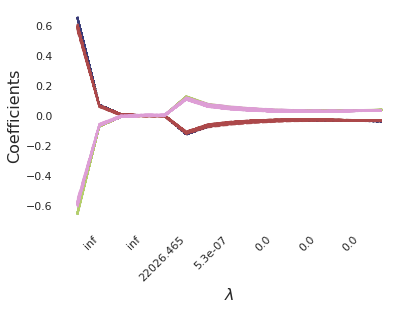

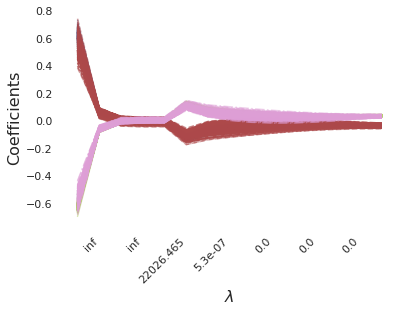

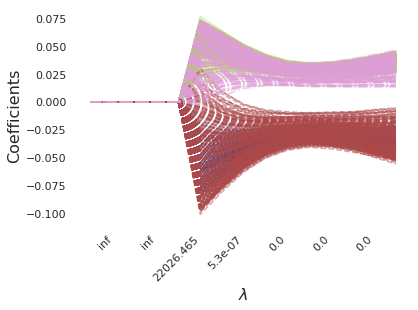

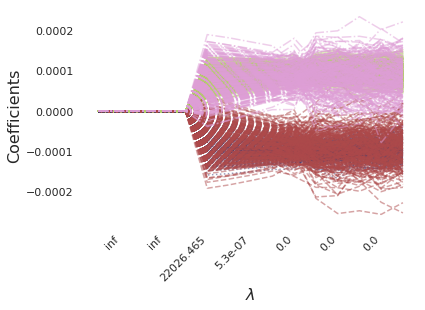

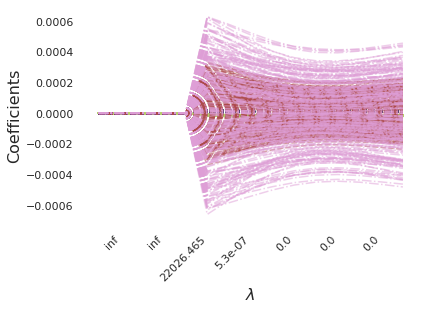

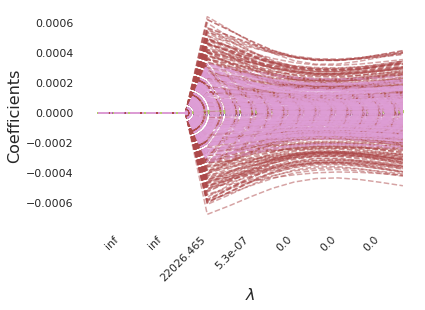

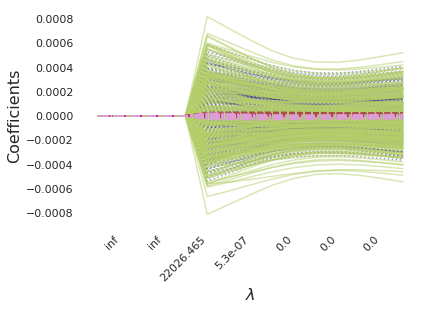

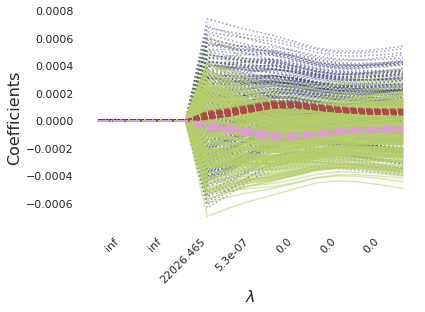

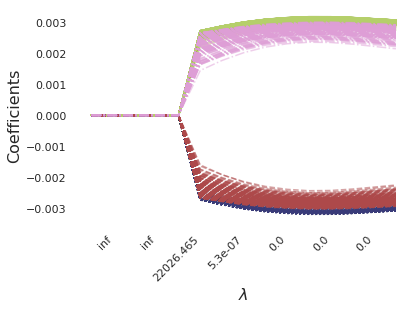

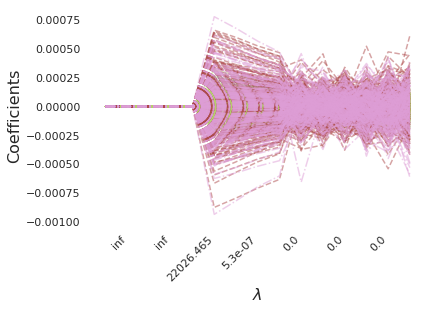

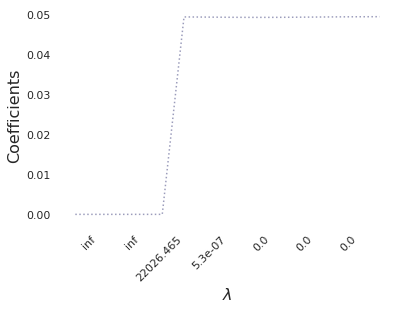

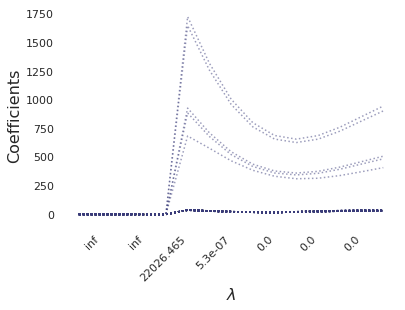

In [53]:
from matplotlib import pyplot as plt
def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set()

    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,len(np.unique(true_clusters)) ))
    else:
        colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[1]))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_facecolor('white')
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
skip=100


path_plot(np.mean(np.asarray(A),axis=2)[:,:,np.newaxis][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(A)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(USV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(UV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,1:2][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,2:3][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,3:4][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,4:5][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,5:6][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(V)[:,0:4,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(S)[:,:,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)



In [54]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]*np.array(S[P]).flatten()@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(A[P])[:,:])
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(X_compB[P])[:,:])
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    import sklearn
    
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(P,sklearn.metrics.adjusted_rand_score(cs,true_clusters_in[0:n_Y]), acc)

if n_Y < 2000:
    # Fit PCMF
    tic=time.time()
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    
from sklearn.decomposition import PCA
tic=time.time()
pca = PCA(n_components=U[0].shape[1])
pca_in = pca.fit_transform(X_in[:,0:n_X])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

k = problem_rank
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), toc)



0 0.0 0.25
1 0.0 0.25
2 0.0 0.25
3 0.0 0.25
4 0.0 0.25
5 0.41068232825939044 0.5724
6 0.4113773566997131 0.57552
7 0.5105997309654051 0.57536
8 0.5221337492410475 0.58239
9 0.8678008551580008 0.94748
10 0.9329597071411397 0.97416
11 0.6932751771949812 0.82357
12 0.8357702189405027 0.9337
13 0.5189023595030994 0.58064
14 0.513426085306056 0.57696
X_c PCA1 kmeans 0.49503380015818027 0.58977 5.5052525997161865
X_c PCA2 kmeans 0.42856377321559075 0.50087 20.514535665512085
X_c kmeans 0.49504658175231736 0.5898 20.514535665512085


In [52]:

k = 8
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), toc)



X_c PCA2 kmeans 0.42856377321559075 0.50087 20.16545534133911
X_c kmeans 0.49504658175231736 0.5898 20.16545534133911


In [55]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
    print(P)
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    PCMF_predict_clusters(X_in_test, UV[P], V, P, cs, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
    PCMF_predict_clusters(X_in_test, X_in, V, P, cs, PCMFtype='Full', true_clusters_test=true_clusters_in_test)

# # %aimport 
# from pcmf import PCMF_predict_clusters
# for P in range(len(penalty_list)):
#     print(P)
#     PCMF_predict_clusters(X_in_test, UV[P], V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
#     PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)



0
Test set cluster accuracy: 0.25
Test set cluster accuracy: 0.25
1
Test set cluster accuracy: 0.25
Test set cluster accuracy: 0.25
2
Test set cluster accuracy: 0.25
Test set cluster accuracy: 0.25
3
Test set cluster accuracy: 0.25
Test set cluster accuracy: 0.25
4
Test set cluster accuracy: 0.25
Test set cluster accuracy: 0.25
5
Test set cluster accuracy: 0.5292
Test set cluster accuracy: 0.5868
6
Test set cluster accuracy: 0.5321
Test set cluster accuracy: 0.5794
7
Test set cluster accuracy: 0.5084
Test set cluster accuracy: 0.5788
8
Test set cluster accuracy: 0.5047
Test set cluster accuracy: 0.5814
9
Test set cluster accuracy: 0.5
Test set cluster accuracy: 0.7115
10
Test set cluster accuracy: 0.5
Test set cluster accuracy: 0.7125
11
Test set cluster accuracy: 0.5161
Test set cluster accuracy: 0.693
12
Test set cluster accuracy: 0.5
Test set cluster accuracy: 0.7104
13
Test set cluster accuracy: 0.5045
Test set cluster accuracy: 0.5812
14


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


Test set cluster accuracy: 0.5059
Test set cluster accuracy: 0.5769


In [70]:
data_path = '/athena/listonlab/store/amb2022/clusterCCA_revision1/clusterCCA/results/pcmf_full_consensus_synthetic_run7_div_fourcluster_ConsensusONLY_n100000_p1000_density0.5_split_size_100_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz'
results = np.load(data_path, allow_pickle=True)

A = results['A']
U = results['U']
V = results['V']
S = results['S']
# UV = results['UV']
# USV = results['USV']
# X_compA = results['X_compA']
# X_compB = results['X_compB']
# X_in = results['X_in']
true_clusters_in = results['true_clusters']
# X_in_test = results['X_in_test']
# true_clusters_in_test = results['true_clusters_in_test']
# true_clusters_labels = results['true_clusters_labels']
# num_clusters = results['num_clusters']
# u_true = results['u_true']
# v_true = results['v_true']
split_size = results['split_size']
toc = results['runtime']
penalty_list = results['penalty_list']
rho = results['rho']
admm_iters = results['admm_iters']
gc = results['gauss_coef']
neighbors = results['neighbors']





In [59]:
print(list(results))

['true_clusters', 'split_size', 'means', 'n_X', 'sigma', 'density', 'seeds', 'A', 'V', 'U', 'S', 'runtime', 'penalty_list', 'rho', 'admm_iters', 'weights', 'gauss_coef', 'neighbors', 'scale_data', 'intercept']


In [66]:
print(results['means'],len(penalty_list))

[-1.   1.  -0.4  0.4] 60


In [ ]:
num_clusters = len(np.unique(true_clusters))
# CALCULATE UV
X_compA = []
X_compB = []
UV = []
USV = []
for p in range(len(penalty_list)):
    x_pcmf = U[p]*S[p][:,0] # should the 0 be here??
    x_pcmf2 = (X_in[:,:] @ V[p].T) 
    X_compA.append(np.array(x_pcmf))
    X_compB.append(np.array(x_pcmf2))
    UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
    USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

X_compA=np.asarray(X_compA)
X_compB=np.asarray(X_compB)


In [72]:
# 
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(10,len(penalty_list)):
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
#         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
#         spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]*np.array(S[P]).flatten()@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]@np.array(V[P])[:,:]))
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(A[P])[:,:])
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(X_compB[P])[:,:])
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(A[P]))
#         kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    import sklearn
    
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(P,sklearn.metrics.adjusted_rand_score(cs,true_clusters_in[0:n_Y]), acc)

if n_Y < 2000:
    # Fit PCMF
    tic=time.time()
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    
from sklearn.decomposition import PCA
tic=time.time()
pca = PCA(n_components=U[0].shape[1])
pca_in = pca.fit_transform(X_in[:,0:n_X])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

k = problem_rank
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), toc)



10 0.05817505036705153 0.3578
11 0.02169060845504848 0.31372
12 0.00232991070822194 0.27427
13 0.006240142080439228 0.28733
14 0.0026606102920068726 0.27398
15 0.002089122299937585 0.27231
16 0.0032060242287837147 0.27609
17 0.002633591504494023 0.27328
18 0.0023093738594285942 0.27168
19 0.0028823786320593928 0.27493
20 0.003426271844882712 0.27799
21 0.003041326522521104 0.27563
22 0.0029954792631308657 0.27517
23 0.003399544015966226 0.27708
24 0.0032920852825797627 0.27633
25 0.0036015155840675495 0.27791
26 0.003934260067705774 0.27921
27 0.005293327318466592 0.28462
28 0.009996861608332387 0.29558
29 0.018304505931637474 0.31112
30 0.040048806551856074 0.34001
31 0.06703615996297707 0.36752
32 0.12191357411442687 0.40644
33 0.18008881812834043 0.4432
34 0.25209914531761934 0.47776
35 0.30066656838234584 0.50101
36 0.32996296308829887 0.51466
37 0.3379113977936135 0.52062
38 0.34125559491339724 0.52425
39 0.34189226400049355 0.54109
40 0.39489911087673063 0.6481
41 0.5707649583914

In [74]:
true_clusters.shape

(10000,)

In [75]:
from pcmf import generate_cluster_PMD_data
# X test
m = 2500
seeds = results['seeds']
n_clusters=4    
ms = [m,m,m,m]
# Get clustered CCA data
X_clusters, u_true, v_true, _=generate_cluster_PMD_data(ms, 1000, results['sigma'], results['density'], 4, means=results['means']) 
X_TEST=np.vstack(X_clusters)
true_clusters_TEST=np.repeat([0,1,2,3],m)

#

In [84]:
X_TEST.shape
A[P].shape
results['true_clusters'].shape

(100000,)

In [87]:
len(A)
num_clusters

4

In [88]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(10,len(penalty_list)):
    print(P)
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(A[P]))
        cs = kmeans.labels_
    PCMF_predict_clusters(X_TEST, A[P], V, P, results['true_clusters'], PCMFtype='Full', true_clusters_test=true_clusters_TEST)

# # %aimport 
# from pcmf import PCMF_predict_clusters
# for P in range(len(penalty_list)):
#     print(P)
#     PCMF_predict_clusters(X_in_test, UV[P], V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
#     PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)



10
Test set cluster accuracy: 0.5
11
Test set cluster accuracy: 0.5
12
Test set cluster accuracy: 0.5
13
Test set cluster accuracy: 0.5
14
Test set cluster accuracy: 0.5
15
Test set cluster accuracy: 0.5
16
Test set cluster accuracy: 0.5
17
Test set cluster accuracy: 0.5
18
Test set cluster accuracy: 0.5
19
Test set cluster accuracy: 0.5
20
Test set cluster accuracy: 0.5
21
Test set cluster accuracy: 0.5
22
Test set cluster accuracy: 0.5
23
Test set cluster accuracy: 0.5
24
Test set cluster accuracy: 0.5
25
Test set cluster accuracy: 0.5
26
Test set cluster accuracy: 0.5
27
Test set cluster accuracy: 0.5
28
Test set cluster accuracy: 0.5
29
Test set cluster accuracy: 0.5
30
Test set cluster accuracy: 0.5
31
Test set cluster accuracy: 0.5
32
Test set cluster accuracy: 0.5
33
Test set cluster accuracy: 0.5
34
Test set cluster accuracy: 0.5
35
Test set cluster accuracy: 0.5
36
Test set cluster accuracy: 0.5
37
Test set cluster accuracy: 0.5
38
Test set cluster accuracy: 1.0
39
Test set cl

In [89]:
k = 1
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
train_clusters = kmeans.labels_

PCMF_predict_clusters(X_TEST, pca_in, vh[np.newaxis,:,:], 0, train_clusters, PCMFtype='Full', true_clusters_test=true_clusters_TEST)



Test set cluster accuracy: 0.5


(array([[ 3.06233080e+01, -8.19986175e-16, -7.07452821e-16, ...,
          8.96984438e-16, -4.92466913e-17, -8.73966251e-16],
        [-2.95877824e+01,  7.96142596e-16,  6.85171919e-16, ...,
         -8.65693073e-16,  4.37100356e-17,  8.49550430e-16],
        [ 2.36228050e+01, -6.43487983e-16, -5.49338722e-16, ...,
          6.93126557e-16, -4.15624406e-17, -6.74951340e-16]]),
 array([1, 1, 1, ..., 2, 2, 2]),
 array([[-1.05374095e+01, -7.64012674e-02,  4.85717445e-02, ...,
         -1.39703580e-02,  2.21883851e-02, -2.41662186e-02],
        [-1.05410495e+01, -2.99131038e-02, -3.71633315e-02, ...,
         -1.06731043e-02,  1.12345438e-01,  1.06401318e-01],
        [-1.04802915e+01, -1.64857164e-02,  1.40678366e-01, ...,
         -2.23623975e-01,  3.37681526e-03, -2.22707852e-01],
        ...,
        [ 4.20977541e+00, -1.49856902e-02, -1.70177478e-02, ...,
          3.13105528e-03, -9.59301883e-02, -1.17349476e-01],
        [ 4.15250693e+00, -2.40944656e-02,  3.67534655e-02, ...,
     

In [91]:
PCMF_predict_clusters(X_TEST, pca_in, vh[np.newaxis,:,:], 0, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_TEST)


Test set cluster accuracy: 0.5


(array([[-2.83141852e-01,  6.21613871e-18,  5.45341550e-18, ...,
         -9.47575352e-18, -1.07469589e-18,  1.45961021e-17],
        [-2.64966270e-01,  1.74182890e-17,  3.30180328e-18, ...,
         -7.69051489e-18, -6.48370246e-19,  9.73554570e-18],
        [ 1.28939559e-02, -4.37871961e-18,  1.92956762e-18, ...,
         -1.67366121e-19, -1.96898053e-18, -2.02837747e-18],
        [ 2.50176140e-01, -7.54063478e-18, -2.03170814e-18, ...,
          1.13059562e-17, -4.79505324e-18, -4.15445456e-18]]),
 array([0, 0, 0, ..., 3, 3, 3]),
 array([[-1.05374095e+01, -7.64012674e-02,  4.85717445e-02, ...,
         -1.39703580e-02,  2.21883851e-02, -2.41662186e-02],
        [-1.05410495e+01, -2.99131038e-02, -3.71633315e-02, ...,
         -1.06731043e-02,  1.12345438e-01,  1.06401318e-01],
        [-1.04802915e+01, -1.64857164e-02,  1.40678366e-01, ...,
         -2.23623975e-01,  3.37681526e-03, -2.22707852e-01],
        ...,
        [ 4.20977541e+00, -1.49856902e-02, -1.70177478e-02, ...,
     